In [543]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.5 MB/s eta 0:00:00


In [514]:
!mkdir -p data/uber_raw
!unzip -j "*.zip" uber-raw-data-apr14.csv uber-raw-data-may14.csv uber-raw-data-jun14.csv uber-raw-data-jul14.csv uber-raw-data-aug14.csv uber-raw-data-sep14.csv -d data/uber_raw

Archive:  uber-raw-data-aug14.csv.zip
  inflating: data/uber_raw/uber-raw-data-aug14.csv  
caution: filename not matched:  uber-raw-data-apr14.csv
caution: filename not matched:  uber-raw-data-may14.csv
caution: filename not matched:  uber-raw-data-jun14.csv
caution: filename not matched:  uber-raw-data-jul14.csv
caution: filename not matched:  uber-raw-data-sep14.csv

Archive:  uber-raw-data-may14.csv.zip
replace data/uber_raw/uber-raw-data-may14.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/uber_raw/uber-raw-data-may14.csv  
caution: filename not matched:  uber-raw-data-apr14.csv
caution: filename not matched:  uber-raw-data-jun14.csv
caution: filename not matched:  uber-raw-data-jul14.csv
caution: filename not matched:  uber-raw-data-aug14.csv
caution: filename not matched:  uber-raw-data-sep14.csv

Archive:  uber-raw-data-sep14.csv.zip
  inflating: data/uber_raw/uber-raw-data-sep14.csv  
caution: filename not matched:  uber-raw-data-apr14.csv
caution: filename not 

In [515]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, average_precision_score, ConfusionMatrixDisplay, precision_recall_curve, roc_curve

In [516]:
# Author: Jhonathan Pauca
# Scope: Classes: TimestampProcessor, Aggregator, FeatureEngineer.
#        Functions:  evaluate_if_vs_heuristic, run_isolation_forest, plot_isolation_forest_outliers, approximate_mv_em_curves
# Organization: Universidad Nacional Mayor de  San Marcos
# Course: Machine Learning and Big Data
# Professor: Víctor Cabrejos
# Description: Anomaly Detection on Uber's Trips in New York City in 2014.

class TimestampProcessor:
    """Handle timestamp processing."""
    def __init__(self, datetime_col: str = 'timestamp'):
        self.datetime_col = datetime_col

    def floor_to_hour(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        df[self.datetime_col] = pd.to_datetime(df[self.datetime_col])
        df['timestamp_hour'] = df[self.datetime_col].dt.floor('H')
        return df


class Aggregator:
    """Aggregate counts per hour."""
    def __init__(self, time_col: str = 'timestamp_hour', value_col: str = 'value'):
        self.time_col = time_col
        self.value_col = value_col

    def aggregate_hourly(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        df[self.time_col] = pd.to_datetime(df[self.time_col])
        agg = df.groupby([self.time_col]).agg(
            **{self.value_col: (self.time_col, 'count')}
        ).reset_index().rename(columns={self.time_col: 'timestamp'})
        return agg


class FeatureEngineer:
    """Add time features, lags, and rolling stats."""
    def __init__(self, rolling_window: int = 24, time_col: str = 'timestamp', value_col: str = 'value'):
        self.rolling_window = rolling_window
        self.time_col = time_col
        self.value_col = value_col

    def add_time_features(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        df['Weekday'] = df[self.time_col].dt.day_name()
        df['Hour'] = df[self.time_col].dt.hour
        df['Day'] = df[self.time_col].dt.dayofweek
        df['Month_day'] = df[self.time_col].dt.day
        df['Month'] = df[self.time_col].dt.month
        df['Year'] = df[self.time_col].dt.year
        return df

    def add_lag_and_rolling(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        df = df.sort_values([self.time_col])
        df['Lag'] = df[self.value_col].shift(1).fillna(0)
        df['Rolling_Mean'] = (
            df[self.value_col]
            .rolling(window=self.rolling_window, min_periods=1)
            .mean()
            .reset_index(level=0, drop=True)
        )
        return df

In [517]:
def run_isolation_forest(model_data: pd.DataFrame, contamination=0.1, n_estimators=200, max_samples=0.7) -> pd.DataFrame:

    IF = (IsolationForest(random_state=42,
                          contamination=contamination,
                          n_estimators=n_estimators,
                          max_samples=max_samples)
         )

    IF.fit(model_data)

    output = pd.Series(IF.predict(model_data)).apply(lambda x: 1 if x == -1 else 0)

    score = IF.decision_function(model_data)

    return output, score, IF

In [518]:
def evaluate_if_vs_heuristic(y_true, y_score, contamination):
    """
    Evaluates the Isolation Forest performance against heuristic labels and plots ROC AUC and PR curves side by side.

    Args:
        y_true (np.array): Binary labels from heuristic method (1 for outlier, 0 for normal).
        y_score (np.array): Anomaly scores from Isolation Forest (lower score is more anomalous).
        contamination (float): Contamination parameter used in Isolation Forest to determine the threshold.
    """
    # Inverse the anomaly scores so that higher score means more anomalous for evaluation metrics
    # that expect this convention (like ROC AUC, AP).
    y_score_inv = -y_score

    # Convert IF scores to binary labels based on contamination
    # We need to find the threshold that corresponds to the given contamination
    # Lower scores are more anomalous. We want to label the lowest 'contamination' proportion as outliers.
    threshold = np.percentile(y_score, 100 * contamination)
    y_pred_label = (y_score <= threshold).astype(int) # 1 for outlier, 0 for normal

    # Evaluate metrics
    roc_auc = None
    avg_prec = None

    # ROC AUC and Average Precision require at least one positive and one negative class
    if len(np.unique(y_true)) > 1 and len(np.unique(y_pred_label)) > 1:
        try:
            roc_auc = roc_auc_score(y_true, y_score_inv)
            avg_prec = average_precision_score(y_true, y_score_inv)
        except ValueError as e:
            print(f"Could not compute ROC AUC or Average Precision: {e}")
            roc_auc = None
            avg_prec = None
    else:
        print("Heuristic labels or Isolation Forest predictions contain only one class. ROC AUC and Average Precision cannot be computed.")


    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot ROC curve if possible
    if roc_auc is not None:
        fpr, tpr, _ = roc_curve(y_true, y_score_inv)
        axes[0].plot(fpr, tpr, label=f'IF (AUC = {roc_auc:.3f})')
        axes[0].plot([0,1], [0,1], 'k--', label='Random')
        axes[0].set_xlabel('False Positive Rate')
        axes[0].set_ylabel('True Positive Rate')
        axes[0].set_title('ROC Curve: IF vs Heuristic labels')
        axes[0].legend()
    else:
        axes[0].set_title('ROC AUC not computable')
        axes[0].text(0.5, 0.5, 'Not enough classes in y_true or y_pred', horizontalalignment='center', verticalalignment='center', transform=axes[0].transAxes)


    # Plot Precision-Recall curve if possible
    if avg_prec is not None:
        precision, recall, _ = precision_recall_curve(y_true, y_score_inv)
        axes[1].plot(recall, precision, label=f'IF (AP = {avg_prec:.3f})')
        axes[1].set_xlabel('Recall')
        axes[1].set_ylabel('Precision')
        axes[1].set_title('Precision-Recall Curve: IF vs Heuristic labels')
        axes[1].legend()
    else:
        axes[1].set_title('Precision-Recall not computable')
        axes[1].text(0.5, 0.5, 'Not enough classes in y_true or y_pred', horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes)

    plt.tight_layout()
    plt.show()

    # Confusion matrix and classification report
    # Ensure y_true and y_pred_label have the same possible classes for consistent confusion matrix
    all_possible_labels = sorted(list(set(np.unique(y_true)).union(set(np.unique(y_pred_label)))))
    cm = confusion_matrix(y_true, y_pred_label, labels=all_possible_labels)
    cr = classification_report(y_true, y_pred_label, target_names=[str(label) for label in all_possible_labels], zero_division=0)

    print("\nClassification Report:")
    print(cr)

    # Create display
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(label) for label in all_possible_labels])

    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title("Isolation Forest vs Heuristic Labels Confusion Matrix")
    n_classes = len(all_possible_labels)
    ax.set_xticks(np.arange(n_classes))
    ax.set_yticks(np.arange(n_classes))
    ax.set_xticklabels([str(label) for label in all_possible_labels])
    ax.set_yticklabels([str(label) for label in all_possible_labels])
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [519]:
def plot_isolation_forest_outliers(trip_counts: pd.DataFrame, outliers: pd.Series):
    """
    Plots the original data and highlights the outliers identified by Isolation Forest.

    Args:
        trip_counts (pd.DataFrame): DataFrame with timestamp as index and 'value' column.
        outliers_IF (pd.Series): Series of outlier labels (1 for outlier, 0 for normal)
                                 from Isolation Forest, with the same index as trip_counts.
    """
    # Select the data points identified as outliers by Isolation Forest
    outlier_points_IF = trip_counts[outliers == 1]

    plt.figure(figsize=(15, 6))
    plt.plot(trip_counts.index, trip_counts['value'], label='Original Data')
    # Plot the outlier points using the original 'value' from trip_counts
    plt.scatter(outlier_points_IF.index, outlier_points_IF['value'], color='red', label='Outliers (Isolation Forest)')

    plt.title('Taxi Demand with Outliers (Isolation Forest Method)')
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.legend()
    plt.show()



In [553]:
def approximate_mv_em_curves(real_scores: np.ndarray, random_scores: np.ndarray, n_thresholds=100):
    """
    Given anomaly scores for real data and random samples (higher = more anomalous),
    approximate Mass-Volume (MV) and Excess-Mass (EM) curves:
    - For thresholds t over score range, compute:
        mass(t) = P_real(score >= t)
        volume(t) = P_random(score >= t)
    - MV curve: plot volume vs mass.
    - EM curve (simple): em(t) = mass(t) - volume(t). Larger em indicates better separation at threshold t.
    Returns DataFrame with columns ['threshold', 'mass', 'volume', 'em'] sorted by decreasing threshold.
    """
    # Determine threshold grid between min and max of combined scores
    combined = np.concatenate([real_scores, random_scores])
    t_min, t_max = np.min(combined), np.max(combined)
    thresholds = np.linspace(t_min, t_max, n_thresholds)
    masses = []
    volumes = []
    ems = []
    n_real = len(real_scores)
    n_rand = len(random_scores)
    for t in thresholds:
        mass = np.sum(real_scores >= t) / n_real
        volume = np.sum(random_scores >= t) / n_rand
        em = mass - volume
        masses.append(mass)
        volumes.append(volume)
        ems.append(em)
    df = pd.DataFrame({
        'threshold': thresholds,
        'mass': masses,
        'volume': volumes,
        'em': ems
    })
    # Sort by threshold descending
    df = df.sort_values('threshold', ascending=False).reset_index(drop=True)
    return df

def sample_random_uniform(X: np.ndarray, n_samples=10000, random_state=42):
    """
    Sample uniformly within bounding hyper-rectangle defined by feature-wise min/max of X.
    Returns random samples in original feature space.
    """
    rng = np.random.RandomState(random_state)
    mins = X.min(axis=0)
    maxs = X.max(axis=0)
    random_samples = rng.uniform(low=mins, high=maxs, size=(n_samples, X.shape[1]))
    return random_samples

In [520]:
# 1) List the six filenames (in the order Apr → Sep)
months = ["apr14", "may14", "jun14"]
base_path = "data/uber_raw"  # adjust as needed

dfs = []
for m in months:
    fname = f"uber-raw-data-{m}.csv"
    path = os.path.join(base_path, fname)
    # read CSV, parse Date/Time, keep only the four columns
    df = pd.read_csv(
        path,
        usecols=["Date/Time", "Lat", "Lon", "Base"],
        parse_dates=["Date/Time"],
        infer_datetime_format=True,
    )
    dfs.append(df)

# 2) Concatenate into one DataFrame
full_df = pd.concat(dfs, ignore_index=True)

In [521]:
#floors each timestamp to the previous 30 min.
full_df["timestamp"] = full_df["Date/Time"].dt.floor('H')

trip_counts = (
    full_df.groupby("timestamp")
    .size()
    .rename("value")
    .reset_index()
)

# Baseline

# Heuristic Methods to Obtain Outliers

Quartil 1: 401.0
Quartil 3: 1219.0
Interquartile Range: 818.0
Lower Bound for outliers: 73.79999999999995
Upper Bound for outliers: 1709.8
Outliers: 209


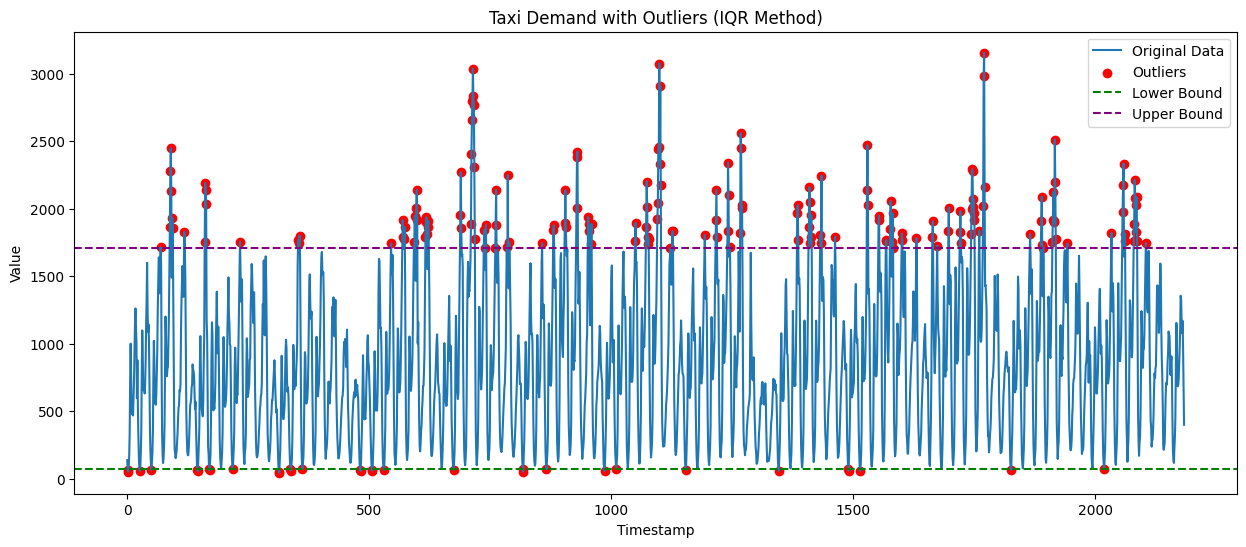

In [522]:
# Use Heuristic most used method to obtain outliers from model_data that contains 'value', 'Hour', 'Day', 'Month_day', 'Month','Rolling_Mean','Lag', 'timestamp'.  value is the number of trips for aggregated timestamp (it is resampled by H). Context taxi trips

# Calculate Q1, Q3 and IQR for 'value'
Q1 = trip_counts['value'].quantile(0.25)
Q3 = trip_counts['value'].quantile(0.75)
IQR = Q3 - Q1
print("Quartil 1:",Q1)
print("Quartil 3:",Q3)
print("Interquartile Range:",IQR)


# Define lower and upper bounds for outliers
lower_bound = Q1 - 0.4 * IQR
upper_bound = Q3 + 0.6 * IQR
print("Lower Bound for outliers:",lower_bound)
print("Upper Bound for outliers:",upper_bound)

# Identify outliers
outliers_IQR = trip_counts[(trip_counts['value'] < lower_bound) | (trip_counts['value'] > upper_bound)]
print("Outliers:",len(outliers_IQR))
# You can also visualize the outliers
plt.figure(figsize=(15, 6))
plt.plot(trip_counts.index, trip_counts['value'], label='Original Data')
plt.scatter(outliers_IQR.index, outliers_IQR['value'], color='red', label='Outliers')

# Add horizontal lines for lower and upper bounds
plt.axhline(y=lower_bound, color='green', linestyle='--', label='Lower Bound')
plt.axhline(y=upper_bound, color='purple', linestyle='--', label='Upper Bound')

plt.title('Taxi Demand with Outliers (IQR Method)')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

# Unsupervised Method to obtain Outliers

---


## Fit Model

In [523]:
outliers_IF, score, _ = run_isolation_forest(trip_counts[["value"]])

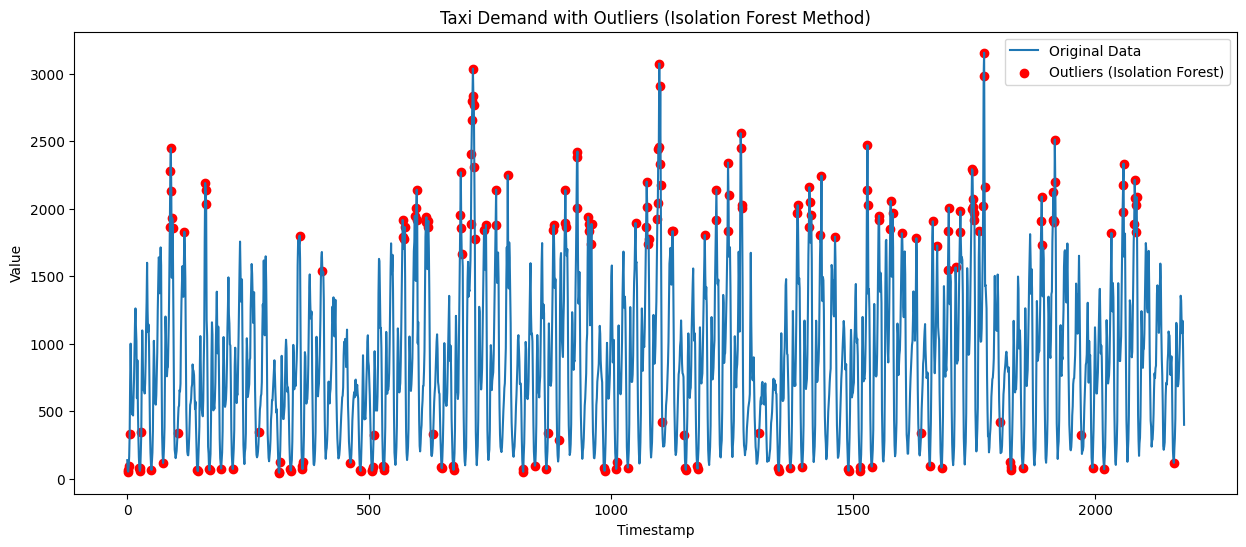

In [524]:
plot_isolation_forest_outliers(trip_counts, outliers_IF)

## Model Evaluation

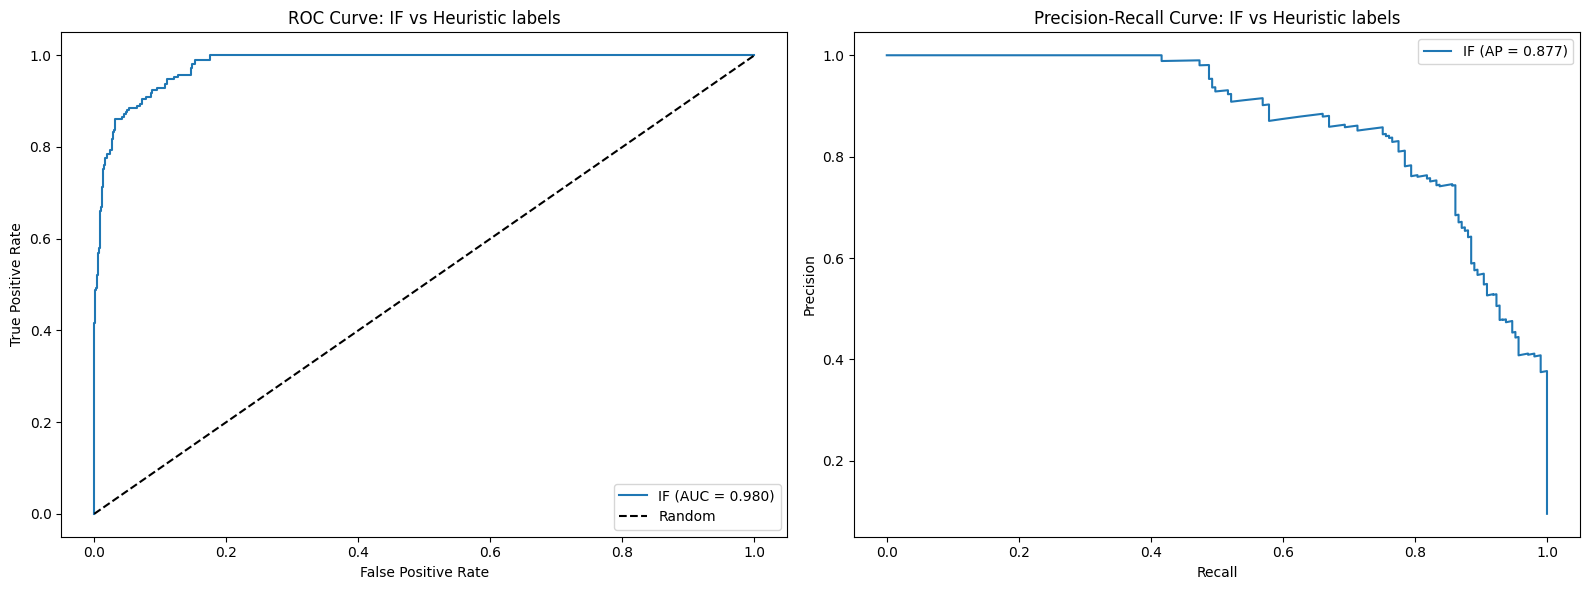


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1975
           1       0.76      0.80      0.78       209

    accuracy                           0.96      2184
   macro avg       0.87      0.89      0.88      2184
weighted avg       0.96      0.96      0.96      2184



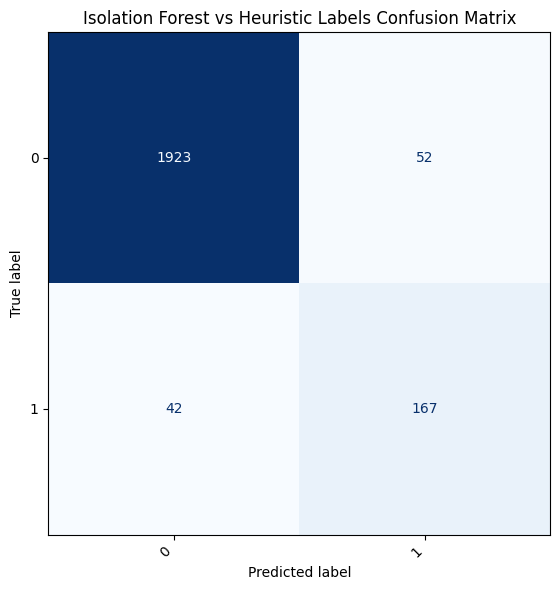

In [525]:
# Prepare heuristic labels
# 1 if outlier, 0 if normal
y_true_heuristic = ((trip_counts['value'] < lower_bound) | (trip_counts['value'] > upper_bound)).astype(int).values

# Use the score from the Isolation Forest run
y_score_if = score

# Define the contamination value used for Isolation Forest
# You should set this to the actual contamination used in run_isolation_forest
if_contamination = 0.1 # Adjust this based on how you ran the IF model

# Evaluate
evaluate_if_vs_heuristic(y_true_heuristic, y_score_if, contamination=if_contamination)

# Second Iteration

## DATA WRANGLING

In [526]:
raw_df = full_df.drop(columns=["timestamp"]).copy()

In [527]:
# 2. Given raw_df with columns ['Date/Time', 'Lat', 'Lon'], rename to standard cols:
raw_df = raw_df.rename(columns={'Date/Time': 'timestamp', 'Lat': 'lat', 'Lon': 'lon'})

In [528]:
# 3. Process timestamps:
ts_proc = TimestampProcessor(datetime_col='timestamp')
df_ts = ts_proc.floor_to_hour(raw_df)

In [529]:
# 5. Aggregate hourly:
aggregator = Aggregator(time_col='timestamp_hour', value_col='value')
df_agg = aggregator.aggregate_hourly(df_ts)

In [530]:
# 6. Feature engineering:
fe = FeatureEngineer(rolling_window=168, time_col='timestamp', value_col='value')
df_feat_result = fe.add_time_features(df_agg)
df_feat_result = fe.add_lag_and_rolling(df_feat_result)

In [531]:
#Clear nulls
df_feat_result.dropna(inplace=True)

# Hourly
model_data = df_feat_result[['value', 'Hour', 'Day', 'Month_day', 'Month','Rolling_Mean','Lag', 'timestamp']].set_index('timestamp').dropna()
model_data.head()

,value,Hour,Day,Month_day,Month,Rolling_Mean,Lag
timestamp,,,,,,,
2014-04-01 00:00:00,138,0,1,1,4,138.000000,0.0
2014-04-01 01:00:00,66,1,1,1,4,102.000000,138.0
2014-04-01 02:00:00,53,2,1,1,4,85.666667,66.0
2014-04-01 03:00:00,93,3,1,1,4,87.500000,53.0
2014-04-01 04:00:00,166,4,1,1,4,103.200000,93.0


## Advanced Heuristic Methods to Obtain Outliers

In [532]:
# Assume model_data is your DataFrame, indexed by timestamp, sorted ascending,
# with columns: 'value', 'Hour', 'Day', 'Month_day', 'Month', 'Rolling_Mean', 'Lag'.
# If Rolling_Mean is not already appropriate window, you can recompute it:

# Define constants for heuristic parameters
WINDOW = 168  # e.g., 24 for hourly daily window
K_MULTIPLIER = 1.5 # Multiplier for Rolling Std-based Deviation (2.5 Default) - Adjusted for lower bound
M_MULTIPLIER = 1.5 # Multiplier for Rolling Median & MAD (3.0 Default) - Adjusted for lower bound
C_MULTIPLIER = 2 # Multiplier for Lag Jump Detection (3.0 Default) - Adjusted for lower bound
ZSCORE_THRESHOLD = 1.4 # Threshold for Seasonal (hourly) Z-score (3.0 Default) - Adjusted for lower bound
VOTATION_THRESHOLD = 2 # Number of heuristics that must agree for a vote (2 Default) - Lowered for more sensitivity


model_data_h = model_data.copy()
model_data_h['Rolling_Mean'] = model_data['value'].rolling(window=WINDOW, min_periods=1).mean()

# 1. Rolling std-based deviation
model_data_h['Rolling_STD'] = model_data['value'].rolling(window=WINDOW, min_periods=1).std().fillna(0)
model_data_h['Deviation'] = (model_data['value'] - model_data_h['Rolling_Mean']).abs()
# To include lower bound outliers, we check if the value is significantly below the mean
model_data_h['Anomaly_RollingStd'] = ((model_data_h['value'] - model_data_h['Rolling_Mean']) < -K_MULTIPLIER * model_data_h['Rolling_STD']) | \
                                     ((model_data_h['value'] - model_data_h['Rolling_Mean']) > K_MULTIPLIER * model_data_h['Rolling_STD'])


# 2. Rolling median & MAD
model_data_h['Rolling_Median'] = model_data_h['value'].rolling(window=WINDOW, min_periods=1).median()
abs_dev = (model_data['value'] - model_data_h['Rolling_Median']).abs()
model_data_h['Rolling_MAD'] = abs_dev.rolling(window=WINDOW, min_periods=1).median().fillna(0)
# To include lower bound outliers, we check if the absolute deviation is large
model_data_h['Anomaly_RollingMAD'] = abs_dev > (M_MULTIPLIER * model_data_h['Rolling_MAD'])


# 3. Lag jump detection
# If 'Lag' column exists and is previous period's value; otherwise create it:
if 'Lag' not in model_data_h.columns:
    model_data_h['Lag'] = model_data_h['value'].shift(1)
model_data_h['Lag_Diff'] = (model_data_h['value'] - model_data_h['Lag']).abs()
# Rolling std of Lag_Diff
model_data_h['RollingStd_LagDiff'] = model_data_h['Lag_Diff'].rolling(window=WINDOW, min_periods=1).std().fillna(0)
# Anomaly is flagged if the absolute jump is too large in either direction
model_data_h['Anomaly_LagJump'] = model_data_h['Lag_Diff'] > (C_MULTIPLIER * model_data_h['RollingStd_LagDiff'])


# 4. Seasonal (hourly) z-score
# Compute historical mean/std by Hour over a longer history.
# For simplicity, use entire data as “historical” here; you may want a moving historical window instead.
hourly_stats = model_data_h.groupby('Hour')['value'].agg(['mean','std']).rename(columns={'mean':'Hour_Mean_hourly_stats','std':'Hour_Std_hourly_stats'})
model_data_h = model_data_h.join(hourly_stats, on='Hour', rsuffix='_hourly_stats') # Add rsuffix here
# Avoid division by zero
# The original code modifies model_data_h['Hour_Std'], which might be ambiguous after the join if no suffix was used.
# Since I've added a suffix, I'll update this line to use the suffixed column name.
model_data_h['Hour_Std_hourly_stats'] = model_data_h['Hour_Std_hourly_stats'].replace(0, np.nan).fillna(method='ffill').fillna(1.0)
model_data_h['Zscore_Hour'] = (model_data_h['value'] - model_data_h['Hour_Mean_hourly_stats']) / model_data_h['Hour_Std_hourly_stats']
# Anomaly is flagged if the absolute Z-score is too high
model_data_h['Anomaly_HourlyZ'] = model_data_h['Zscore_Hour'].abs() > ZSCORE_THRESHOLD

# 5. Composite voting
heuristics = ['Anomaly_RollingStd', 'Anomaly_RollingMAD', 'Anomaly_LagJump', 'Anomaly_HourlyZ']
model_data_h['Heuristic_Score'] = model_data_h[heuristics].sum(axis=1)
# Flag if at least VOTATION_THRESHOLD heuristics agree
model_data_h['Anomaly_Vote'] = model_data_h['Heuristic_Score'] >= 2

# Review flagged anomalies
anomalies = model_data_h[model_data_h['Anomaly_Vote']]
print(f"Total anomalies flagged: {len(anomalies)}")

# Display all rows and specified columns of the anomalies DataFrame
# Adjust pandas display options to show all columns
with pd.option_context('display.max_columns', None):
  display(anomalies[['value','Rolling_Mean','Rolling_STD','Lag','Lag_Diff','Hour_Mean_hourly_stats','Hour_Std_hourly_stats','Heuristic_Score']])

Total anomalies flagged: 332


,value,Rolling_Mean,Rolling_STD,Lag,Lag_Diff,Hour_Mean_hourly_stats,Hour_Std_hourly_stats,Heuristic_Score
timestamp,,,,,,,,
2014-04-01 05:00:00,333,141.500000,103.120803,166.0,167.0,354.065934,133.463337,3
2014-04-01 06:00:00,722,224.428571,238.750118,333.0,389.0,676.296703,332.615577,3
2014-04-01 07:00:00,1001,321.500000,352.478976,722.0,279.0,913.967033,455.164377,3
2014-04-01 09:00:00,532,388.400000,346.324575,780.0,248.0,689.494505,233.011272,2
2014-04-01 15:00:00,967,479.437500,314.431968,736.0,231.0,1318.648352,305.600733,3
...,...,...,...,...,...,...,...,...
2014-06-29 00:00:00,1105,928.702381,531.718821,1492.0,387.0,442.846154,355.112812,2
2014-06-29 04:00:00,242,933.428571,528.529092,545.0,303.0,227.923077,55.691857,2
2014-06-29 07:00:00,270,933.821429,528.007591,237.0,33.0,913.967033,455.164377,2


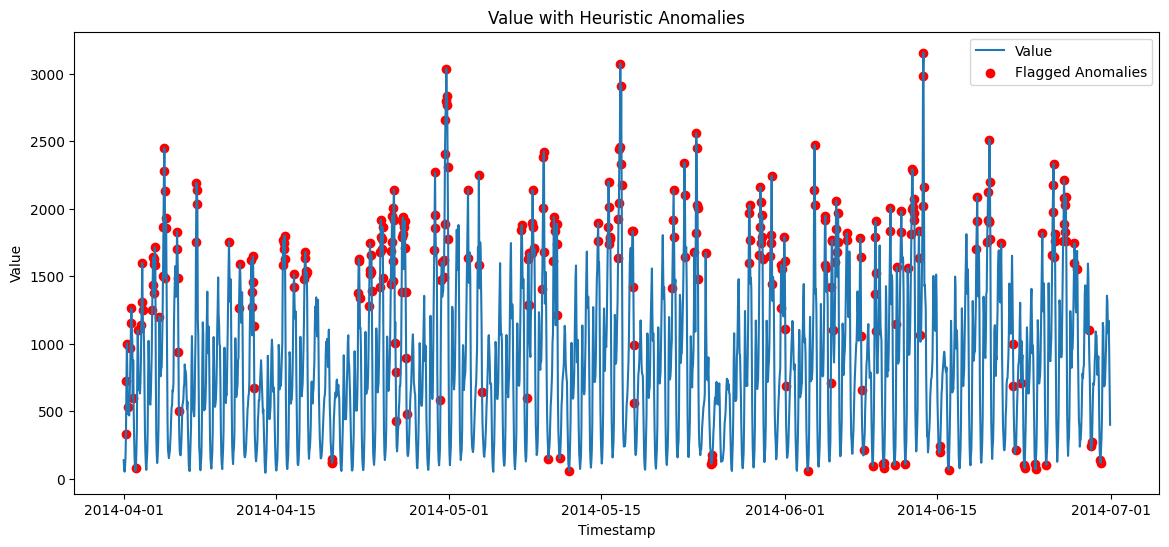

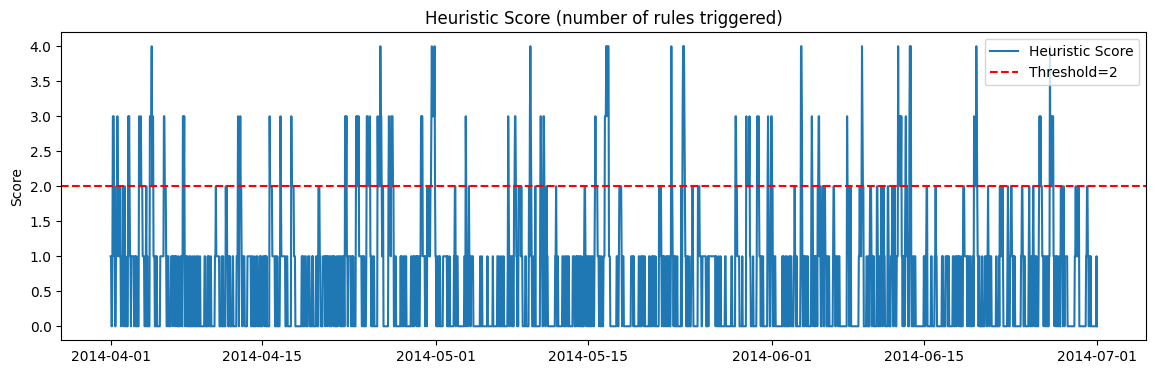

In [533]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(model_data_h.index, model_data_h['value'], label='Value')
plt.scatter(anomalies.index, anomalies['value'], color='red', label='Flagged Anomalies')
plt.title('Value with Heuristic Anomalies')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

# Also plot the heuristic score over time
plt.figure(figsize=(14,4))
plt.plot(model_data_h.index, model_data_h['Heuristic_Score'], label='Heuristic Score')
plt.axhline(2, color='red', linestyle='--', label='Threshold=2')
plt.title('Heuristic Score (number of rules triggered)')
plt.ylabel('Score')
plt.legend()
plt.show()

# Unsupervised Method to obtain Outliers

### Feature Encoding

In [534]:
# 3. For readability, create a reference to the DatetimeIndex
ts = model_data.index
model_data_encoded = model_data.copy()
# 4. Compute cyclical encodings
model_data_encoded['hour_sin']  = np.sin(2 * np.pi * ts.hour / 24)
model_data_encoded['hour_cos']  = np.cos(2 * np.pi * ts.hour / 24)
model_data_encoded['dow_sin']   = np.sin(2 * np.pi * ts.dayofweek / 7)
model_data_encoded['dow_cos']   = np.cos(2 * np.pi * ts.dayofweek / 7)
# Note: month from 1 to 12; using (month-1) so that month=1 maps to angle=0
model_data_encoded['month_sin'] = np.sin(2 * np.pi * (ts.month - 1) / 12)
model_data_encoded['month_cos'] = np.cos(2 * np.pi * (ts.month - 1) / 12)

# 5. Optionally drop raw columns if not needed downstream
#    If you want to drop Hour, Day, Month_day, Month because you now use cyclical:
cols_to_drop = ['Hour', 'Day', 'Month_day', 'Month']
for col in cols_to_drop:
    if col in model_data.columns:
        model_data_encoded = model_data_encoded.drop(columns=[col])

# 6. Inspect the result
print(model_data_encoded.head())


                     value  Rolling_Mean    Lag  hour_sin  hour_cos   dow_sin  \
timestamp                                                                       
2014-04-01 00:00:00    138    138.000000    0.0  0.000000  1.000000  0.781831   
2014-04-01 01:00:00     66    102.000000  138.0  0.258819  0.965926  0.781831   
2014-04-01 02:00:00     53     85.666667   66.0  0.500000  0.866025  0.781831   
2014-04-01 03:00:00     93     87.500000   53.0  0.707107  0.707107  0.781831   
2014-04-01 04:00:00    166    103.200000   93.0  0.866025  0.500000  0.781831   

                     dow_cos  month_sin     month_cos  
timestamp                                              
2014-04-01 00:00:00  0.62349        1.0  6.123234e-17  
2014-04-01 01:00:00  0.62349        1.0  6.123234e-17  
2014-04-01 02:00:00  0.62349        1.0  6.123234e-17  
2014-04-01 03:00:00  0.62349        1.0  6.123234e-17  
2014-04-01 04:00:00  0.62349        1.0  6.123234e-17  


## Hyperparameters Tunning

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import StandardScaler

# Define the features to use for the model
features = ['value','Rolling_Mean','Lag', 'hour_sin', 'hour_cos', 'dow_sin', 'month_sin', 'month_cos']
X = model_data_encoded[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, index=X.index, columns=features)


# Define the target variable (heuristic labels)
# Using the heuristic vote as the 'ground truth' for the Bayesian search
y_true_heuristic = (model_data_h['Heuristic_Score'] >= VOTATION_THRESHOLD).astype(int).values
y = y_true_heuristic

# Define the parameter space for Bayesian Search
param_space = {
    'n_estimators': Integer(50, 300),         # Number of trees in the forest
    'max_samples': Real(0.25, 1.0),           # The number of samples to draw from X to train each base estimator
    'contamination': Real(0.01, 0.3)          # The proportion of outliers in the data set
}


def ap_scorer(estimator, X, y):
    """Custom scorer to compute Average Precision Score."""
    try:
        # Get anomaly scores (lower is more anomalous)
        scores = estimator.decision_function(X)
        return average_precision_score(y, -scores)
    except Exception as e:
        print(f"Error during scoring: {e}")
        return -1.0

model = IsolationForest(random_state=42)

# Create the BayesSearchCV object
bayes_search = BayesSearchCV(
    estimator=model,
    search_spaces=param_space,
    n_iter=150,
    random_state=42,
    scoring=ap_scorer,
    n_jobs=-1,
    cv=3,
    verbose=2
)

print("Starting Bayesian Optimization...")

bayes_search.fit(X_scaled_df, y)

print("\nBayesian Optimization finished.")

best_params = bayes_search.best_params_
print(f"\nBest parameters found: {best_params}")

best_score = bayes_search.best_score_
print(f"Best Average Precision Score: {best_score:.4f}")

final_model = IsolationForest(random_state=42, **best_params)
final_model.fit(X_scaled_df)

# Predict outliers and get scores using the final model
final_outliers = pd.Series(final_model.predict(X_scaled_df)).apply(lambda x: 1 if x == -1 else 0)
final_score = final_model.decision_function(X_scaled_df)


# Bayesian Optimization finished.

# Best parameters found: OrderedDict([('contamination', 0.22259749155264613), ('max_samples', 0.25122854798042094), ('n_estimators', 50)])
# Best Average Precision Score: 0.6232


Evaluating the final model with best parameters:


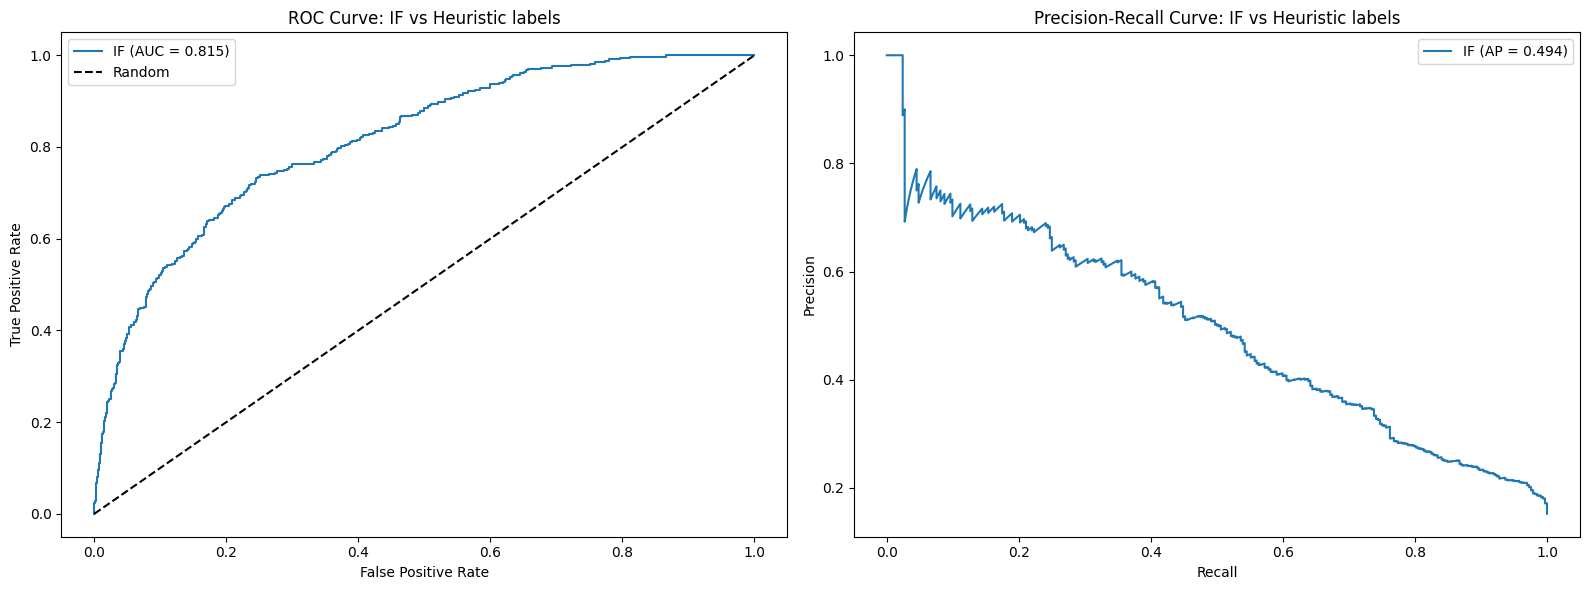


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88      1852
           1       0.41      0.60      0.49       332

    accuracy                           0.81      2184
   macro avg       0.67      0.72      0.68      2184
weighted avg       0.84      0.81      0.82      2184



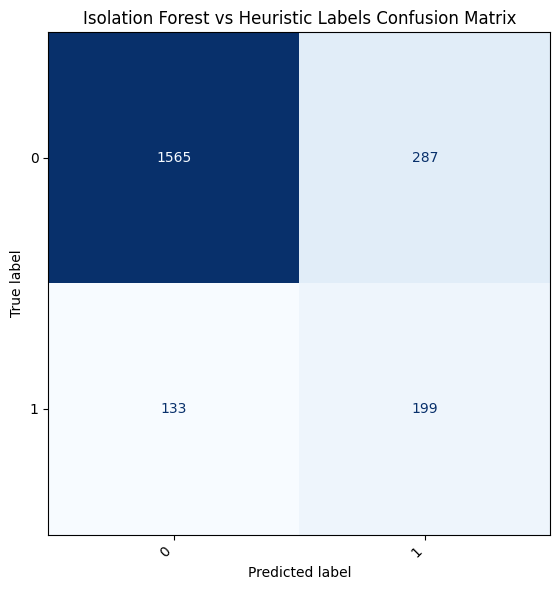

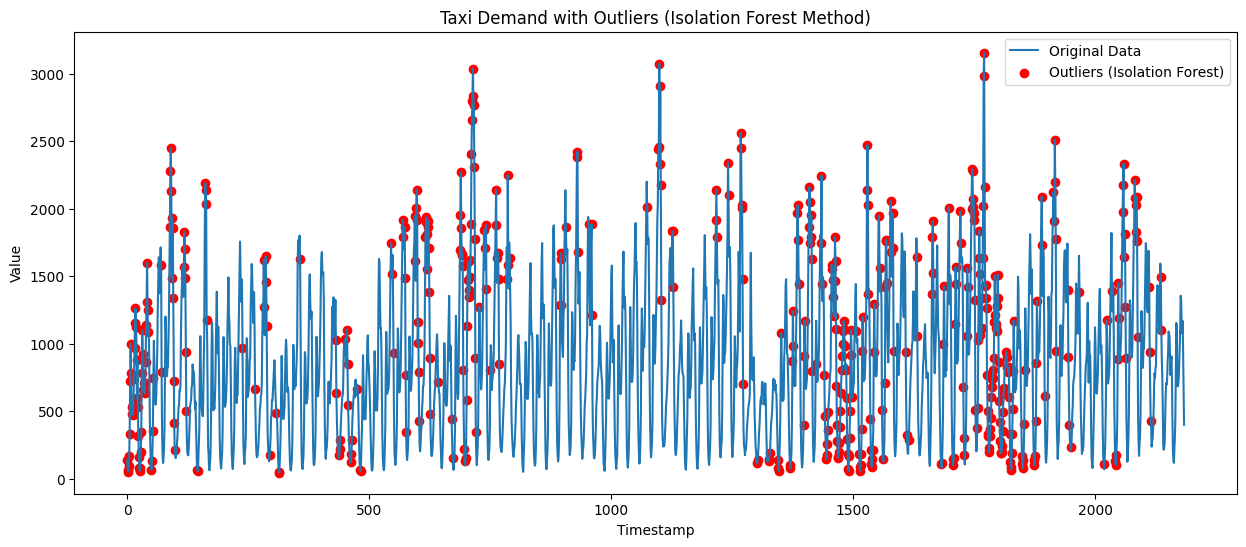

In [546]:
print("\nEvaluating the final model with best parameters:")
evaluate_if_vs_heuristic(y_true_heuristic, final_score, contamination=best_params['contamination'])

df_final_score_plot = (model_data_encoded.reset_index()
             .assign(Outliers = final_outliers)
             .assign(Score = final_score)
            )
plot_isolation_forest_outliers(df_final_score_plot, final_outliers)

## Fit Model

In [556]:
CONS_CONTAMINATION = 0.22

In [557]:
outliers_full_IF, score_full, _ = run_isolation_forest(
    model_data_encoded[['value','Rolling_Mean','Lag', 'hour_sin', 'hour_cos', 'dow_sin', 'month_sin', 'month_cos']], CONS_CONTAMINATION, n_estimators=50, max_samples=0.25)

In [558]:
outliers_full_IF.value_counts()

,count
0,1703
1,481


In [559]:
df_hourly_score = (model_data_encoded.reset_index()
             .assign(Outliers = outliers_full_IF)
             .assign(Score = score_full)
            )

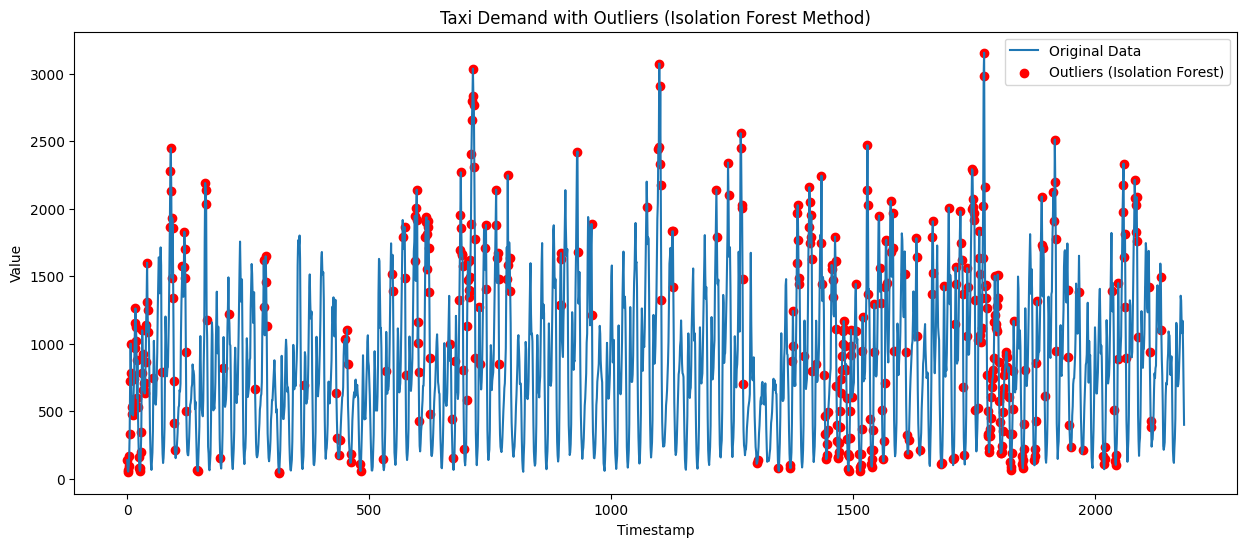

In [560]:
plot_isolation_forest_outliers(df_hourly_score, outliers_full_IF)

## Model Evaluation

### Mass Volume & Excess Mass Curves

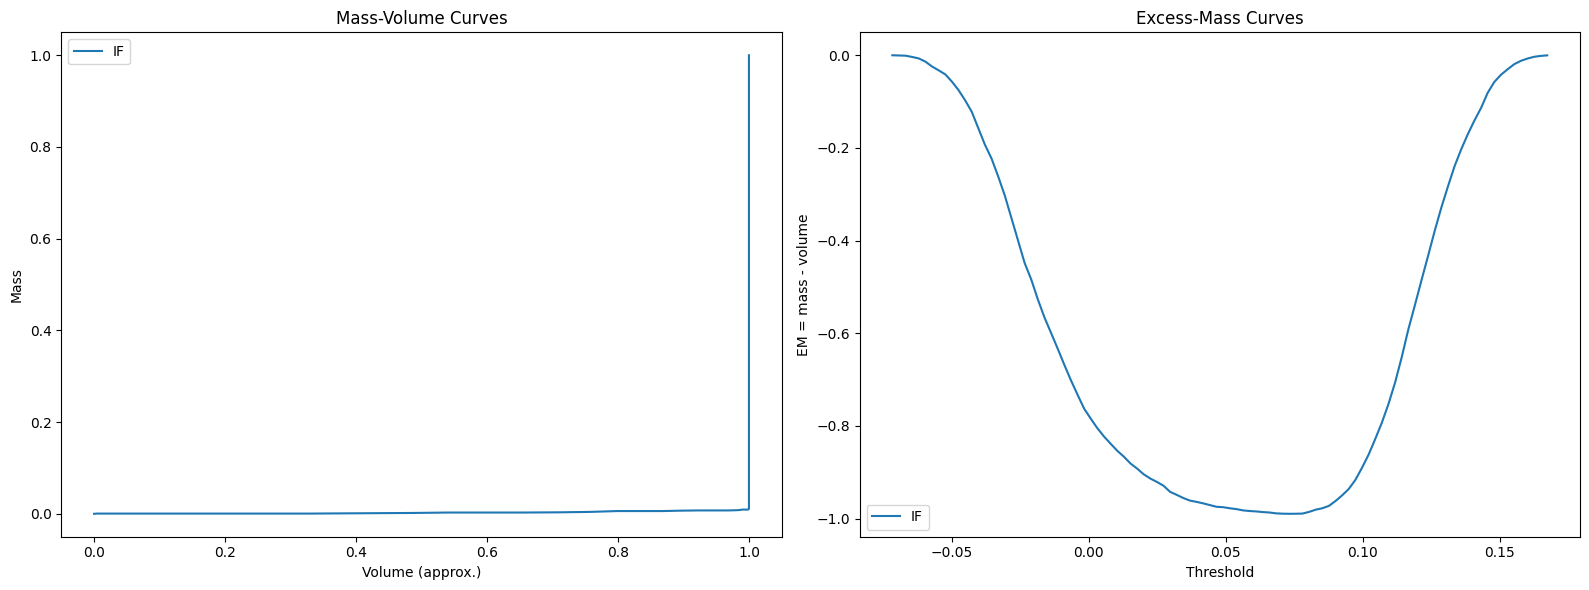

In [564]:
feature_cols = ['value','Rolling_Mean','Lag', 'hour_sin', 'hour_cos', 'dow_sin', 'month_sin', 'month_cos']
scaler = StandardScaler()
scaler.fit(model_data_encoded[feature_cols])
_, score, if_model = run_isolation_forest(model_data_encoded[feature_cols], CONS_CONTAMINATION, n_estimators=50, max_samples=0.25)
X = model_data_encoded[feature_cols].values
scaler.fit(X)
random_X = sample_random_uniform(X, n_samples=5000)
random_scores = {}
random_scores['if'] = -if_model.decision_function(scaler.transform(random_X))

# Compute MV/EM curves
mv_em = {}
real_sc = -score
rand_sc = random_scores['if']
df_curve = approximate_mv_em_curves(real_sc, rand_sc, n_thresholds=100)
mv_em['if'] = df_curve

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot MV curves
axes[0].plot(df_curve['volume'], df_curve['mass'], label='IF')
axes[0].set_xlabel('Volume (approx.)')
axes[0].set_ylabel('Mass')
axes[0].set_title('Mass-Volume Curves')
axes[0].legend()

# Plot EM curves
axes[1].plot(df_curve['threshold'], df_curve['em'], label='IF')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('EM = mass - volume')
axes[1].set_title('Excess-Mass Curves')
axes[1].legend()
plt.tight_layout()
plt.show()

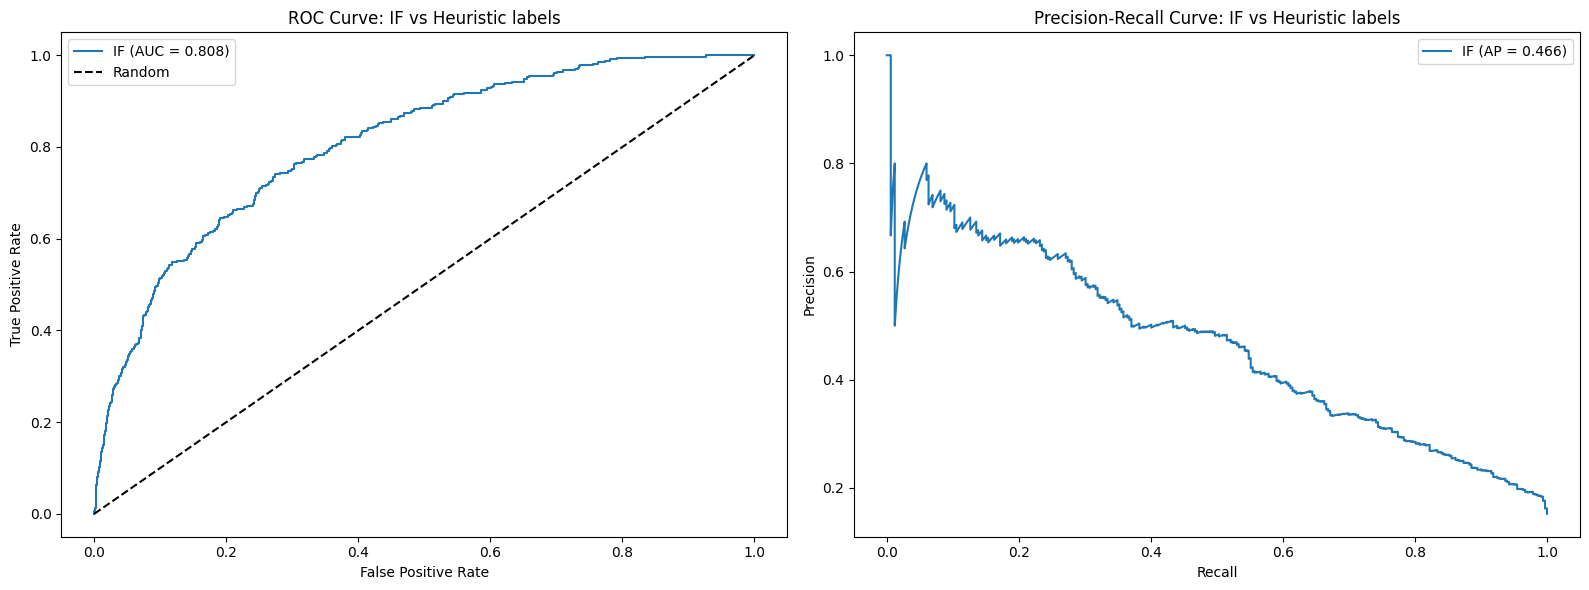


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88      1852
           1       0.41      0.59      0.48       332

    accuracy                           0.81      2184
   macro avg       0.66      0.72      0.68      2184
weighted avg       0.84      0.81      0.82      2184



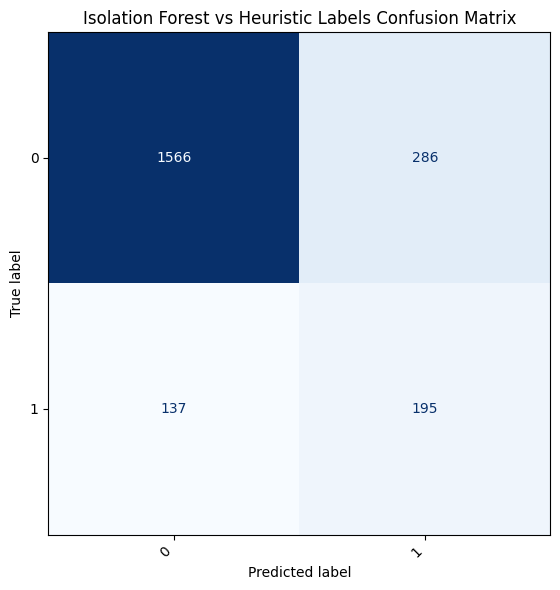

In [562]:
# Prepare heuristic labels
# 1 if outlier, 0 if normal
votation_threshold = 2
y_true_heuristic = (model_data_h['Heuristic_Score'] >= votation_threshold).astype(int).values

# Use the score from the Isolation Forest run
y_score_if = score_full

# Define the contamination value used for Isolation Forest
# You should set this to the actual contamination used in run_isolation_forest
if_contamination = CONS_CONTAMINATION # Adjust this based on how you ran the IF model

# Evaluate
evaluate_if_vs_heuristic(y_true_heuristic, y_score_if, contamination=if_contamination)